# Training a parametric t-SNE model on MNIST digits

This notebook is a demonstration of parametric t-SNE trained on MNIST digits

In [1]:
import os
import gzip
import json
import pickle
from typing import Optional, Tuple

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [5]:
from ptsne import train_parametric_tsne_model

### Training settings and hyperparameters are controlled by config

__The `config` object incorporates information from `config.yaml`__  
__Rename `example.config.yaml` to `config.yaml` before starting__  

In [6]:
from config import config

In [7]:
if config.seed:
    torch.manual_seed(config.seed)
dev = torch.device(config.dev)
    
print(f"Training on {dev}", flush=True)

Training on cuda


### Load MNIST digits from gzip archive

In [8]:
def load_mnist_some_classes(path: str, 
                            include_labels: Optional[Tuple] = None, 
                            n_rows: Optional[int] = None) -> Tuple[torch.tensor]:
    """
    A function that loads MNIST from file
    :param path: path to archive with MNIST
    :param include_labels: a tuple with numbers between 0 and 9 
    representing classes to include
    :param n_rows: number of data points to include 
    :return:
    """
    with gzip.open(path, 'rb') as f:
        train_set, _, _ = pickle.load(f, encoding='latin1')
    train_data, train_labels = train_set
    if include_labels is None:
        include_labels = tuple(range(10))
    keep_indexes = np.in1d(train_labels, include_labels)
    train_data = train_data[keep_indexes]
    train_labels = train_labels[keep_indexes]
    if n_rows is None or n_rows > train_labels.shape[0]:
        n_rows = train_labels.shape[0]

    return train_data[:n_rows], train_labels[:n_rows]

In [9]:
mnist_path = "data/mnist.pkl.gz"

__Split data into train and test__

In [10]:
all_points, all_labels = load_mnist_some_classes(mnist_path)
X_train, X_test, labels_train, labels_test = train_test_split(all_points, 
                                                              all_labels, 
                                                              test_size=0.15)
dim_input = X_train.shape[1]

points_train = torch.tensor(X_train).to(dev)
labels_train = torch.tensor(labels_train)
points_train_ds = TensorDataset(points_train, labels_train)

points_test = torch.tensor(X_test).to(dev)
labels_test = torch.tensor(labels_test)
points_test_ds = TensorDataset(points_test, labels_test)

### Train parametric t-SNE model on train dataset 

__`config` object is passed as argument__

In [11]:
# uncomment to train a new model

train_parametric_tsne_model(points_train_ds, dim_input, config)

100%|██████████| 85/85 [00:07<00:00, 10.87it/s]

====> Epoch: 1. Time 0:00:07.821324. Average loss: 2.3905



100%|██████████| 85/85 [00:07<00:00, 11.14it/s]

====> Epoch: 2. Time 0:00:07.628672. Average loss: 0.6610



100%|██████████| 85/85 [00:07<00:00, 11.03it/s]

====> Epoch: 3. Time 0:00:07.708781. Average loss: 0.4193



100%|██████████| 85/85 [00:07<00:00, 11.12it/s]

====> Epoch: 4. Time 0:00:07.642012. Average loss: 0.3079



100%|██████████| 85/85 [00:07<00:00, 11.12it/s]

====> Epoch: 5. Time 0:00:07.641597. Average loss: 0.2421



100%|██████████| 85/85 [00:07<00:00, 11.01it/s]

====> Epoch: 6. Time 0:00:07.721375. Average loss: 0.2004



100%|██████████| 85/85 [00:07<00:00, 11.29it/s]

====> Epoch: 7. Time 0:00:07.530522. Average loss: 0.1703



100%|██████████| 85/85 [00:07<00:00, 11.39it/s]

====> Epoch: 8. Time 0:00:07.466686. Average loss: 0.1472



100%|██████████| 85/85 [00:07<00:00, 11.08it/s]

====> Epoch: 9. Time 0:00:07.676184. Average loss: 0.1306



100%|██████████| 85/85 [00:07<00:00, 11.34it/s]

====> Epoch: 10. Time 0:00:07.498270. Average loss: 0.1171
Model saved as saved_models/tsne_voyrkx_epoch_10
Loss history saved in saved_models/tsne_voyrkx_epoch_10_loss.npy
Training time: 0:01:16.353944


__The trained model is saved under a unique name__

In [12]:
model_name = "tsne_voyrkx_epoch_10"

__If a model is saved, it produces three files__ 

In [13]:
# Weights of a torch model
model_weights = os.path.join(config.save_dir_path, model_name) + ".pt"

# Json with model's config
model_settings = os.path.join(config.save_dir_path, model_name) + ".json"

# Model's learning curve
model_losses = os.path.join(config.save_dir_path, model_name) + "_loss.npy"

### Test the model

__Check model's config__

In [14]:
with open(model_settings) as f:
    settings = json.load(f)
    for field, v in settings.items():
        print(f"=={field}==")
        print(v)

==device==
cuda
==seed==
170
==optimization==
{'lr': 0.002}
==training==
{'perplexity': None, 'n_epochs': 10, 'early_exaggeration': 4, 'early_exaggeration_constant': 5, 'batch_size': 500, 'bin_search_max_iter': 100, 'bin_search_tol': 0.0001, 'dist_func_name': 'euc', 'min_allowed_sig_sq': 0, 'max_allowed_sig_sq': 10000}


'perplexity': None means the model is _multiscale_

__Plot learning curve__

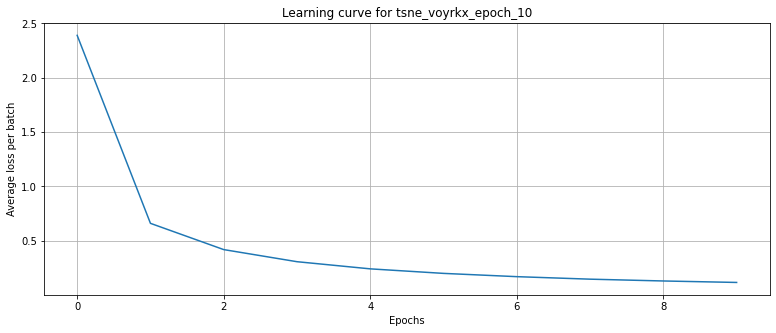

In [15]:
def plot_loss(model_losses_path: str) -> None:
    """
    Plot learning curve for a model given the path 
    to model's saved loss values.
    """
    loss = np.load(model_losses_path)
    
    plt.figure(figsize=(13, 5))
    plt.plot(loss)
    plt.title(f"Learning curve for {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Average loss per batch")
    plt.grid()
    plt.show()
    
plot_loss(model_losses)

__Load model weights to check model's performance on MNIST with test dataset__

In [16]:
loaded_model = torch.load(model_weights)

In [17]:
bs = config.training_params["batch_size"]

In [22]:
def get_batch_embeddings(pretrained_model: torch.nn.Module,
                         input_points: Dataset,
                         batch_size: int):
    """
    Yields final embeddings for every batch in dataset
    """
    pretrained_model.eval()
    test_dl = DataLoader(input_points, batch_size=batch_size, shuffle=False)
    for batch_points, batch_labels in test_dl:
        with torch.no_grad():
            embeddings = pretrained_model(batch_points)
            yield embeddings, batch_labels


def plot_embs(pretrained_model: torch.nn.Module,
              input_points_train: Dataset,
              input_points_test: Dataset,
              batch_size: int):
    """
    Plots projection of training points and test points
    """
    plt.figure(figsize=(13, 10))
    ax = plt.gca()
    for embeddings, batch_labels in get_batch_embeddings(pretrained_model, 
                                                         input_points_train, 
                                                         batch_size):
        x1 = embeddings[:, 0].detach().cpu().numpy()
        x2 = embeddings[:, 1].detach().cpu().numpy()
        ax.scatter(x1, x2, c=batch_labels, s=10, cmap="hsv", alpha=0.2)
    
    for embeddings, batch_labels in get_batch_embeddings(pretrained_model, 
                                                         input_points_test, 
                                                         batch_size):
        x1 = embeddings[:, 0].detach().cpu().numpy()
        x2 = embeddings[:, 1].detach().cpu().numpy()
        ax.scatter(x1, x2, c=batch_labels, s=8, cmap="hsv", alpha=1, edgecolors="k")
    plt.title("MNIST digits parametric t-SNE projection")
    plt.show()

### Visualize MNIST projection

__Blurred points are training points__  
__Points with edge are test points__

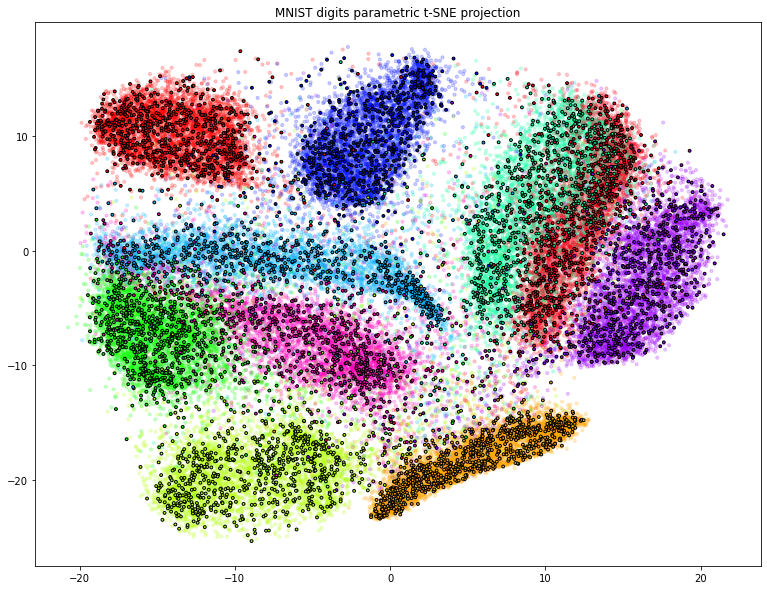

In [23]:
plot_embs(loaded_model, points_train_ds, points_test_ds, bs)